In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
import statsmodels.api as sm
import itertools
from pandas.tseries.offsets import MonthBegin
from statsmodels.sandbox.stats.runs import runstest_1samp
import statsmodels.api as sm # prueba de Box-Pierce y la modificación de Ljung-Box
import pylab as py
from matplotlib import pyplot as plt # gráficos 
from scipy import stats
import seaborn as sns

# Dumificamos las variables y hacemos protocolo de evaluación 

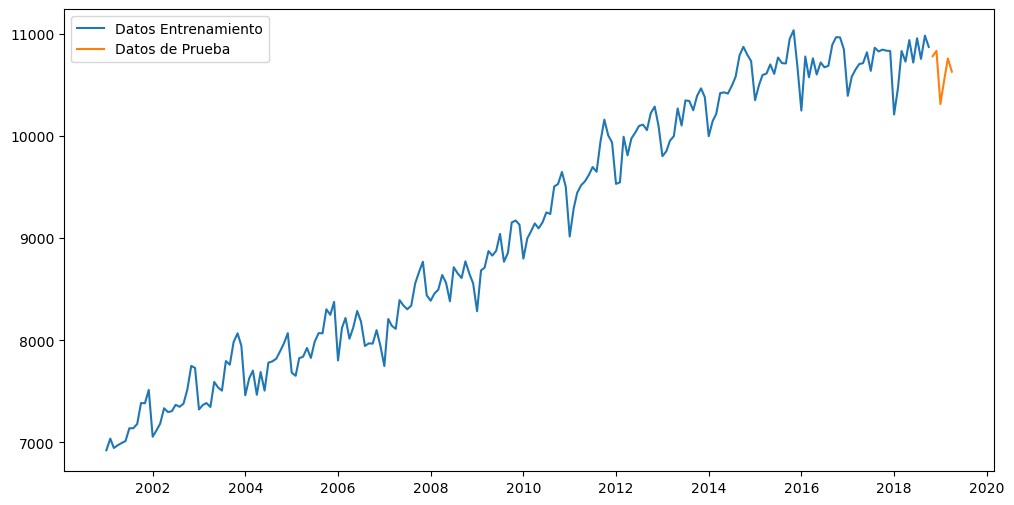

In [2]:
data = pd.read_excel("datosEmpleo.xlsx",index_col='mes',parse_dates=True)
data.head()

month_dummies = pd.get_dummies(data.index.month, drop_first=True).set_index(data.index)
month_dummies = month_dummies.astype(float) # para arreglar el problema de casteo
month_dummies = pd.concat([data, month_dummies], axis=1)# Añadir las variables dummy al final del DataFrame original


#Dividimos el dataset en train y test, considerando 6 meses a predecir
train_data = month_dummies.iloc[:-6]
test_data = month_dummies.iloc[-6:]

fig = plt.figure(figsize=(12, 6))
plt.plot(train_data["Ocupados"],label="Datos Entrenamiento")
plt.plot(test_data["Ocupados"],label="Datos de Prueba")
plt.legend()
plt.show()

# Comparativo de modelos desde grado 1 (Regresión lineal) hasta grado 10, sin considerar y considerando estacionalidad.

In [3]:
# Inicializar una lista para almacenar los resultados
rmse_results = []

for grado in range(1, 11):
    # Modelo sin estacionalidad
    y_train = train_data["Ocupados"]
    x_train = np.linspace(1, train_data.shape[0], train_data.shape[0])
    X_train = np.vander(x_train, N=grado+1)
    
    lin = sm.OLS(y_train, X_train)
    lin_t = lin.fit()

    y_test = test_data["Ocupados"]
    x_test = np.linspace(len(train_data) + 1, len(data), len(test_data))
    X_test = np.vander(x_test, N=grado+1)

    y_pred = lin_t.predict(X_test)
    rmse_sin_estacionalidad = np.sqrt(mean_squared_error(y_test, y_pred))

    # Modelo con estacionalidad
    X_train_season = np.concatenate([X_train, train_data.iloc[:, 4:].values], axis=1)
    lin_season = sm.OLS(y_train, X_train_season)
    lin_t_season = lin_season.fit()

    X_test_season = np.concatenate([X_test, test_data.iloc[:, 4:].values], axis=1)
    y_pred_season = lin_t_season.predict(X_test_season)
    rmse_con_estacionalidad = np.sqrt(mean_squared_error(y_test, y_pred_season))

    # Almacenar los resultados en la lista
    rmse_results.append({
        'Grado': grado,
        'Sin Estacionalidad': rmse_sin_estacionalidad,
        'Con Estacionalidad': rmse_con_estacionalidad
    })

# Convertir la lista de resultados en un DataFrame
rmse_results_df = pd.DataFrame(rmse_results)

# Mostrar la tabla de resultados
rmse_results_df


,Grado,Sin Estacionalidad,Con Estacionalidad
0,1,718.651675,657.508980
1,2,646.597813,590.479496
2,3,238.469108,130.743939
3,4,222.843611,221.621692
4,5,219.947167,91.006689
5,6,337.129999,225.178930
6,7,3709.346672,3709.348872
7,8,6086.663086,6086.663089
8,9,8655.081671,8655.081671
9,10,13431.660407,13431.660407


El mejor modelo de acuerdo con el protocolo de evaluación es una regresión de grado 5 con estacionalidad, observamos el comparativo de la predicción vs los datos reales:

Coeficientes del modelo (Betas):
x1       8.625089e-08
x2      -5.370993e-05
x3       1.120143e-02
x4      -8.958470e-01
x5       4.223479e+01
const    6.588641e+03
x6       1.712018e+02
x7       2.353168e+02
x8       2.374569e+02
x9       2.967677e+02
x10      2.555894e+02
x11      3.310670e+02
x12      3.052980e+02
x13      3.643789e+02
x14      4.742364e+02
x15      4.924690e+02
x16      3.906222e+02
dtype: float64


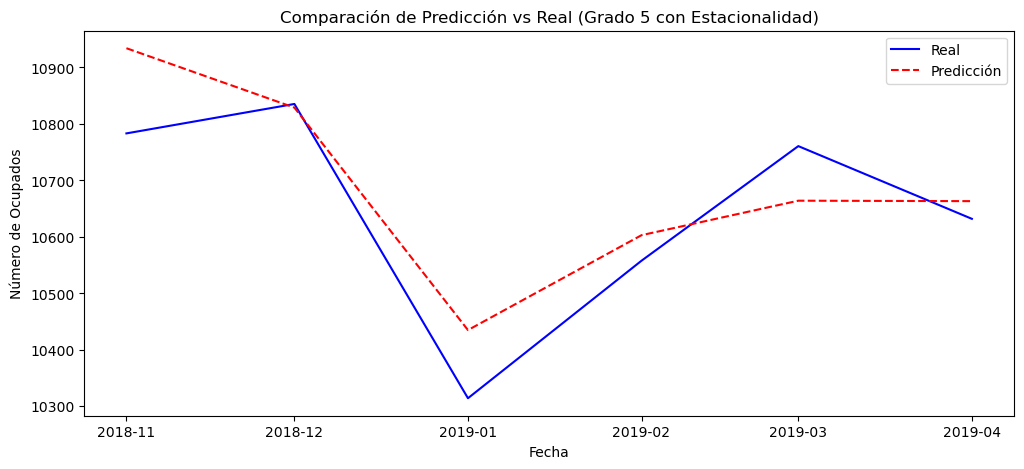

In [15]:
# Mejor modelo: Grado 5 con estacionalidad
grado = 5

# Preparar las variables para el modelo
y_train = train_data["Ocupados"]
x_train = np.linspace(1, train_data.shape[0], train_data.shape[0])
X_train = np.vander(x_train, N=grado+1)

# Añadir las variables dummy (estacionalidad)
X_train_season = np.concatenate([X_train, train_data.iloc[:, 4:].values], axis=1)

# Ajustar el modelo de regresión lineal polinómico con estacionalidad
lin_season = sm.OLS(y_train, X_train_season)
lin_t_season = lin_season.fit()

# Preparar los datos de prueba
y_test = test_data["Ocupados"]
x_test = np.linspace(len(train_data) + 1, len(data), len(test_data))
X_test = np.vander(x_test, N=grado+1)
X_test_season = np.concatenate([X_test, test_data.iloc[:, 4:].values], axis=1)


# Obtener los coeficientes (betas) del modelo
betas = lin_t_season.params

# Mostrar los betas
print("Coeficientes del modelo (Betas):")
print(betas)

# Realizar la predicción
y_pred_season = lin_t_season.predict(X_test_season)

# Gráfico de Predicción vs Real
plt.figure(figsize=(12, 5))
plt.plot(test_data.index, y_test, label='Real', color='blue')
plt.plot(test_data.index, y_pred_season, label='Predicción', color='red', linestyle='--')
plt.title('Comparación de Predicción vs Real (Grado 5 con Estacionalidad)')
plt.xlabel('Fecha')
plt.ylabel('Número de Ocupados')
plt.legend()
plt.show()

            Ocupados   Predicción
mes                              
2001-01-01  6923.604  6629.991243
2001-02-01  7037.746  6840.817935
2001-03-01  6945.973  6942.897760
2001-04-01  6973.079  6981.406827
2001-05-01  6994.462  7075.553469


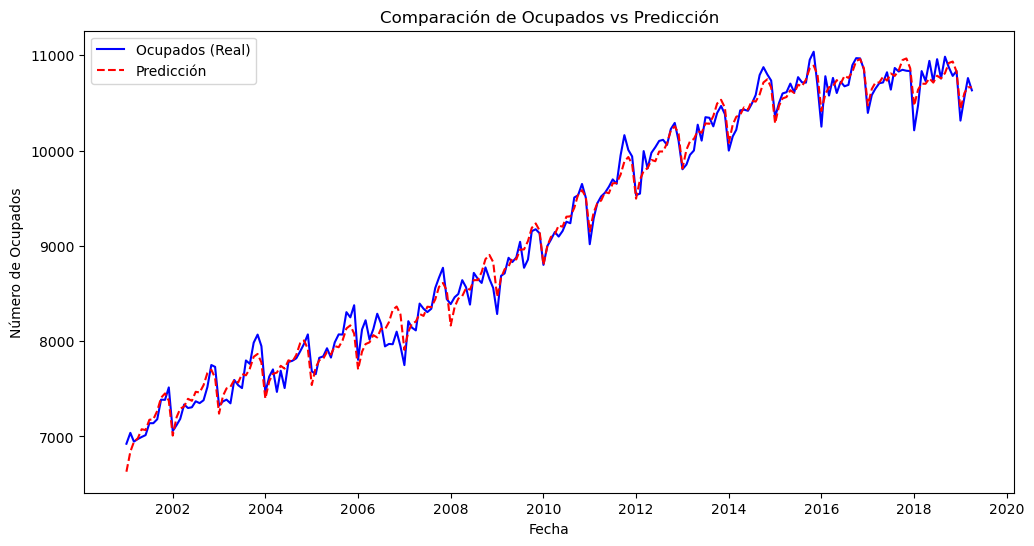

In [20]:
# Preparar las variables para todo el dataset (220 datos)
x_full = np.linspace(1, len(month_dummies), len(month_dummies))
X_full = np.vander(x_full, N=grado+1)

# Añadir las variables dummy (estacionalidad)
X_full_season = np.concatenate([X_full, month_dummies.iloc[:, 4:].values], axis=1)

# Usar los betas para predecir los valores
y_pred_full = np.dot(X_full_season, betas)

# Añadir las predicciones al DataFrame original
month_dummies['Predicción'] = y_pred_full

# Mostrar las primeras filas del DataFrame con la predicción
print(month_dummies[['Ocupados', 'Predicción']].head())

# Generar el gráfico de "Ocupados" vs "Predicción"
plt.figure(figsize=(12, 6))
plt.plot(month_dummies.index, month_dummies['Ocupados'], label='Ocupados (Real)', color='blue')
plt.plot(month_dummies.index, month_dummies['Predicción'], label='Predicción', color='red', linestyle='--')
plt.title('Comparación de Ocupados vs Predicción')
plt.xlabel('Fecha')
plt.ylabel('Número de Ocupados')
plt.legend()
plt.show()

# Validación de supuestos sobre los residuales

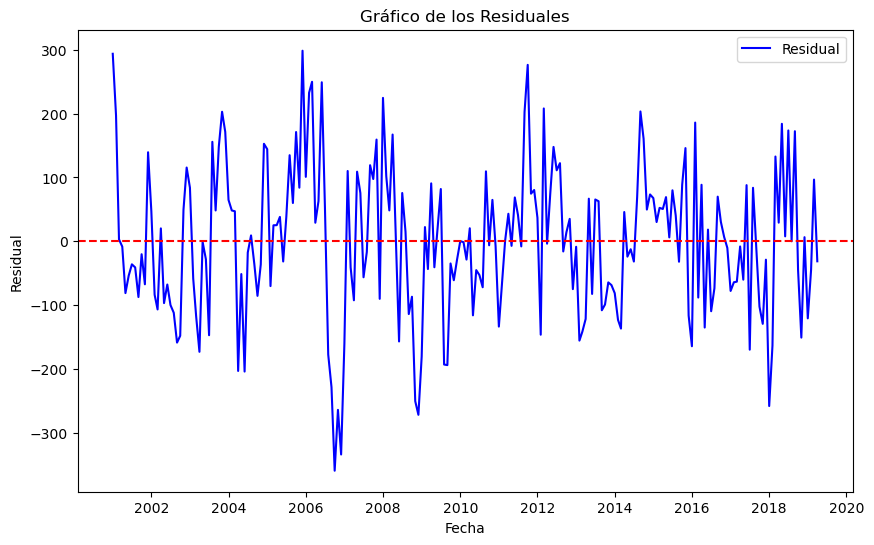

In [21]:
# Calcular los residuales
month_dummies['Residual'] = month_dummies['Ocupados'] - month_dummies['Predicción']

# Graficar los residuales
plt.figure(figsize=(10, 6))
plt.plot(month_dummies.index, month_dummies['Residual'], label='Residual', color='blue')
plt.title('Gráfico de los Residuales')
plt.xlabel('Fecha')
plt.ylabel('Residual')
plt.axhline(y=0, color='red', linestyle='--')
plt.legend()
plt.show()

### *A.Validación de supuesto de Autocorrelación*


Para determinar si existe autocorrelación vamos a usar la prueba de rachas propuesta por Wald y Wolfowitz, 1940. Es una prueba no paramétrica donde las hipótesis son las siguientes:

$H{0}: ρ = 0$ (Es decir no hay autocorrelación) 

$H{1}: ρ \not= 0$ (Es decir hay autocorrelación)

Rechazo $H{0}$ cuando el p-valor es menor al nivel de significancia, convencionalmente se usa un $α$=0.05 ($α$ = nivel de significancia).

In [22]:
residuales=month_dummies.copy()
signo=residuales["Residual"]>0
runstest_1samp(signo, correction=False)

(-3.918414349512615, 8.913339043189346e-05)

El segundo valor corresponde al p-valor=8.913339043189346e-05, por lo tanto considerando un $α$=0.05, los resultados obtenidos permiten rechazar la hipótesis nula, es decir,  se sugiere que existe autocorrelación entre las variables **- Presenta autocorrelación**. 

Este análisis debe complementarse con otras pruebas como la prueba de Box-Pierce y la modificación de Ljung-Box para muestras pequeñas.

In [23]:
# prueba de Box-Pierce y la modificación de Ljung-Box 
sm.stats.acorr_ljungbox(residuales["Residual"], lags=[1], return_df=True,boxpierce=True ) # Se puede hacer para un solo lag.

,lb_stat,lb_pvalue,bp_stat,bp_pvalue
1,35.385054,2.705550e-09,34.906878,3.458570e-09


Con el resultado anterior rechazamos la hipótesis nula de no autocorrelación para el primer rezago, lo ideal antes de tomar la decisión 
Es probar por lo menos los primeros 40 rezagos.

In [24]:
Resul_lb_bp = sm.stats.acorr_ljungbox(residuales["Residual"], lags=range(1,41), return_df=True,boxpierce=True )
Resul_lb_bp["lb_ho"] = np.where(Resul_lb_bp['lb_pvalue']<0.05, 'rechazo_ho/hay_autocorr', 'no_rechazo_ho/no_hay_autocorr')
Resul_lb_bp["bp_ho"] = np.where(Resul_lb_bp['bp_pvalue']<0.05, 'rechazo_ho/hay_autocorr', 'no_rechazo_ho/no_hay_autocorr')

Resul_lb_bp

,lb_stat,lb_pvalue,bp_stat,bp_pvalue,lb_ho,bp_ho
1,35.385054,2.705550e-09,34.906878,3.458570e-09,rechazo_ho/hay_autocorr,rechazo_ho/hay_autocorr
2,54.130260,1.761016e-12,53.314333,2.648133e-12,rechazo_ho/hay_autocorr,rechazo_ho/hay_autocorr
3,64.513083,6.375407e-14,63.463308,1.069074e-13,rechazo_ho/hay_autocorr,rechazo_ho/hay_autocorr
4,65.111071,2.438230e-13,64.045134,4.088713e-13,rechazo_ho/hay_autocorr,rechazo_ho/hay_autocorr
5,65.415329,9.190528e-13,64.339799,1.536091e-12,rechazo_ho/hay_autocorr,rechazo_ho/hay_autocorr
6,66.091020,2.582151e-12,64.991140,4.331966e-12,rechazo_ho/hay_autocorr,rechazo_ho/hay_autocorr
7,68.231328,3.361997e-12,67.044679,5.831717e-12,rechazo_ho/hay_autocorr,rechazo_ho/hay_autocorr
8,71.820018,2.131744e-12,70.471716,3.958540e-12,rechazo_ho/hay_autocorr,rechazo_ho/hay_autocorr
9,72.661570,4.568035e-12,71.271570,8.571419e-12,rechazo_ho/hay_autocorr,rechazo_ho/hay_autocorr
10,75.342994,4.079716e-12,73.808052,8.113172e-12,rechazo_ho/hay_autocorr,rechazo_ho/hay_autocorr


En el anterior data frame las columnas lb_ho y bp_ho nos permiten entender la decisión a tomar al usar las dos pruebas, en general para los rezagos se observa el mismo comportamiento, por lo tanto se puede concluir que la serie **NO** parece comportarse como un ruido blanco, **presenta autocorrelación**.

### *B.Homoscedasticidad y Heteroscedasticidad*

Ahora nos queda por chequear si existe problemas de heteroscedasticidad, en
especial un comportamiento tipo ARCH o GARCH, esto implica que la varianza de la serie tenga un comportamiento no autocorrelacionado.

Una aproximación para determinar si existe un comportamiento GARCH o
ARCH es emplear la prueba de Ljung-Box sobre la serie (sin media) al cuadrado.

$H{0}:$ Comportamiento Homoscedastico (Es decir varianza constante) 

$H{1}:$ Comportamiento Heteroscedastico (Es decir varianza no constante)

In [25]:
sm.stats.acorr_ljungbox((residuales["Residual"]-residuales["Residual"].mean())**2, lags=range(1,21), return_df=True,boxpierce=True )

,lb_stat,lb_pvalue,bp_stat,bp_pvalue
1,23.991582,9.675780e-07,23.667372,1.145076e-06
2,37.038677,9.060529e-09,36.479383,1.198402e-08
3,38.255875,2.494990e-08,37.669168,3.321076e-08
4,39.962024,4.407408e-08,39.329204,5.956607e-08
5,40.432439,1.221602e-07,39.784786,1.650277e-07
6,42.069438,1.781625e-07,41.362794,2.456127e-07
7,42.078355,5.022402e-07,41.371350,6.869668e-07
8,44.658364,4.271320e-07,43.835142,6.112512e-07
9,45.356076,7.927570e-07,44.498283,1.142234e-06
10,49.433562,3.391776e-07,48.355364,5.344835e-07


Dado que los valores p son tan bajos, podemos concluir que existe heteroscedasticidad en los residuos al cuadrado. Esto indica que la varianza de los errores no es constante a lo largo del tiempo, y que podría haber un comportamiento tipo ARCH (Autoregressive Conditional Heteroskedasticity) o GARCH (Generalized Autoregressive Conditional Heteroskedasticity).

### *C. Normalidad*
Finalmente, podemos evaluar si la serie sigue una distribución normal o no. Noten que esto no es necesario para ser ruido blanco, solo para ser ruido blanco gaussiano. Primero hagamos un análisis gráfico empleando las siguientes lineas de código.

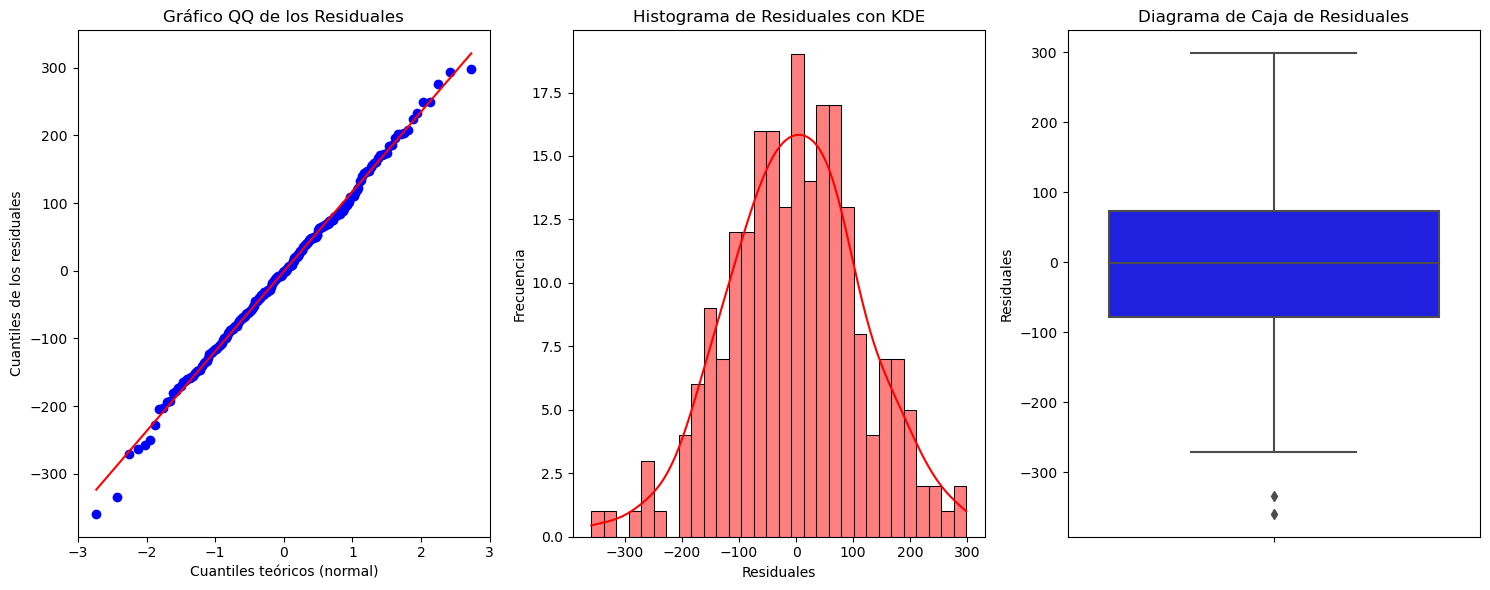

In [26]:
residuos=residuales["Residual"]
# Comprobación gráfica para la normalidad de los residuos
fig, axes = plt.subplots(1, 3, figsize=(15, 6))

# Gráfico QQ de los Residuales
stats.probplot(residuos, dist="norm", plot=axes[0])
axes[0].set_title('Gráfico QQ de los Residuales')
axes[0].set_xlabel('Cuantiles teóricos (normal)')
axes[0].set_ylabel('Cuantiles de los residuales')

# Histograma de Residuales
sns.histplot(residuos, kde=True, bins=30, color='r', edgecolor='k', ax=axes[1])
axes[1].set_xlabel('Residuales')
axes[1].set_ylabel('Frecuencia')
axes[1].set_title('Histograma de Residuales con KDE')

# Diagrama de Caja de Residuales
sns.boxplot(y=residuos, color='blue', ax=axes[2])
axes[2].set_ylabel('Residuales')
axes[2].set_title('Diagrama de Caja de Residuales')

fig.tight_layout()
plt.show()

In [27]:
stats.shapiro(residuales["Residual"])


ShapiroResult(statistic=0.9968739748001099, pvalue=0.94193434715271)

In [28]:
stats.jarque_bera(residuales["Residual"])

SignificanceResult(statistic=0.2621876857664828, pvalue=0.8771354576083467)

Para ambas pruebas, no se puede rechazar la hipótesis de que los datos provienen de una distribución normal. Así, parece ser que los residuos provienen de un proceso ruido blanco gaussiano.

## *Resumen*
1. Hay autocorrelación - No cumple supuesto
2. Hay heterocedasticidad - No cumple supuesto
3. Hay Normalidad - Si cumple supuesto

# Realizamos la predicción para los proximos 6 meses

            Ocupados    Predicción
2001-01-01  6923.604   6629.991243
2001-02-01  7037.746   6840.817935
2001-03-01  6945.973   6942.897760
2001-04-01  6973.079   6981.406827
2001-05-01  6994.462   7075.553469
...              ...           ...
2019-06-01       NaN  10676.125441
2019-07-01       NaN  10749.267581
2019-08-01       NaN  10721.437533
2019-09-01       NaN  10778.769244
2019-10-01       NaN  10887.228117

[226 rows x 2 columns]


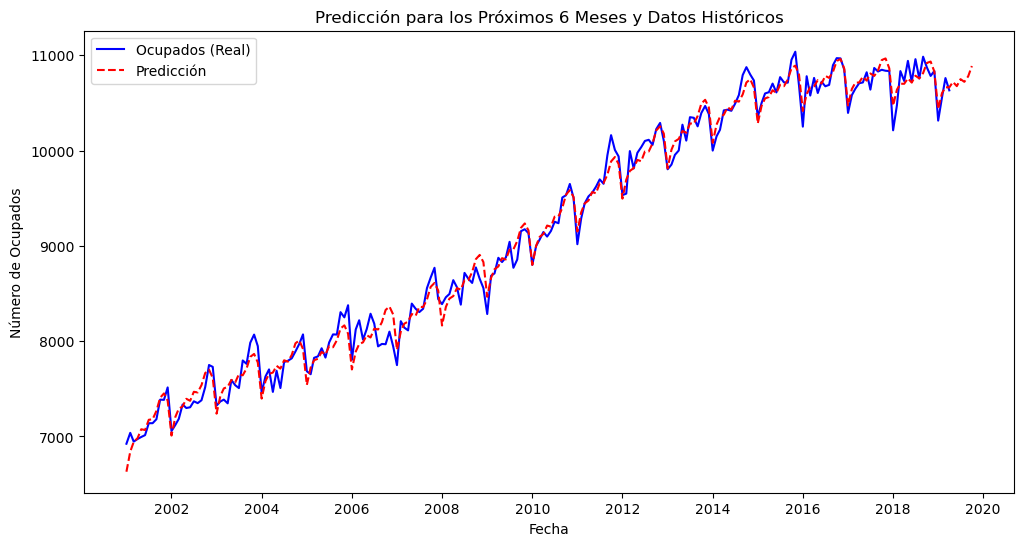

In [29]:
# Paso 1: Extender el dataset original para incluir los próximos 6 meses

# Obtener el índice del último mes del dataset original
start_date = data.index[-1] + MonthBegin(1)

# Generar las nuevas fechas, que serán el primer día de cada mes
new_dates = pd.date_range(start=start_date, periods=6, freq='MS')

# Crear un DataFrame vacío para las nuevas filas
new_data = pd.DataFrame(index=new_dates, columns=data.columns)

# Concatenar las nuevas filas al dataset original
data_extended = pd.concat([data, new_data])

# Paso 2: Dumificar las nuevas fechas

# Crear las variables dummy para todo el dataset extendido (incluyendo los nuevos meses)
month_dummies = pd.get_dummies(data_extended.index.month, drop_first=True).set_index(data_extended.index)
month_dummies = month_dummies.astype(float)

# Paso 3: Concatenar las dummies al dataset extendido
data_extended_with_dummies = pd.concat([data_extended, month_dummies], axis=1)

# Paso 4: Realizar la predicción utilizando el modelo ajustado

# Preparar las variables para la predicción futura
x_future = np.linspace(1, len(data_extended_with_dummies), len(data_extended_with_dummies))
X_future = np.vander(x_future, N=grado+1)

# Añadir las variables dummy (estacionalidad) a las variables futuras
X_future_season = np.concatenate([X_future, data_extended_with_dummies.iloc[:, 4:].values], axis=1)

# Usar los betas para predecir los valores futuros
y_pred_future = np.dot(X_future_season, betas)

# Añadir las predicciones al DataFrame extendido
data_extended_with_dummies['Predicción'] = y_pred_future

# Mostrar las primeras filas del DataFrame extendido con la predicción
print(data_extended_with_dummies[['Ocupados', 'Predicción']])

# Graficar las predicciones para todo el periodo, incluyendo los próximos 6 meses
plt.figure(figsize=(12, 6))
plt.plot(data_extended_with_dummies.index, data_extended_with_dummies['Ocupados'], label='Ocupados (Real)', color='blue')
plt.plot(data_extended_with_dummies.index, data_extended_with_dummies['Predicción'], label='Predicción', color='red', linestyle='--')
plt.title('Predicción para los Próximos 6 Meses y Datos Históricos')
plt.xlabel('Fecha')
plt.ylabel('Número de Ocupados')
plt.legend()
plt.show()

In [30]:
#Predicciones
data_extended_with_dummies[['Predicción']].tail(6)

,Predicción
2019-05-01,10719.876846
2019-06-01,10676.125441
2019-07-01,10749.267581
2019-08-01,10721.437533
2019-09-01,10778.769244
2019-10-01,10887.228117
